<a href="https://colab.research.google.com/github/Raoina/Spectra-2-Image/blob/main/notebooks/Models/PLS_single_target_700_spliting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ================== 0. Imports ==================
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter

In [54]:
!ls /content

Moi_cv_pp_ps.png	    sample_data
Moi_pls_model_pp_ps.joblib  spectra_train_700.csv
Moi_test_pp_ps.png	    Starch_cv_pp_ps.png
Moi_training_pp_ps.png	    Starch_pls_model_pp_ps.joblib
NDF_cv_pp_ps.png	    Starch_test_pp_ps.png
NDF_pls_model_pp_ps.joblib  Starch_training_pp_ps.png
NDF_test_pp_ps.png	    target_train_700.csv
NDF_training_pp_ps.png


In [3]:
# ================== 1. Read Data ==================
# Features (spectra)
X = pd.read_csv("/content/spectra_train_700.csv").values

# Targets
y_df = pd.read_csv("/content/target_train_700.csv")

print("Columns in target_train_700.csv:")
display(y_df.columns)

Columns in target_train_700.csv:


Index(['Moi', 'NDF', 'Starch'], dtype='object')

In [43]:
# Select target column (change if needed: 'Moi', 'Starch', etc.)
target_column = 'Moi'
y = y_df[target_column].values.ravel()

# Split into train/test (instead of separate test file)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("\n✅ Data loaded and split:")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


✅ Data loaded and split:
Shape of X_train: (588, 257)
Shape of y_train: (588,)
Shape of X_test: (196, 257)
Shape of y_test: (196,)


In [45]:
# ================== 2. Preprocessing ==================
def transmission_to_absorbance(X):
    # Avoid division by zero or log of zero/negative numbers
    X = np.clip(X, 1e-10, None)
    return np.log10(1 / X)

def snv(X):
    X = np.asarray(X, dtype=float)
    mean = np.mean(X, axis=1, keepdims=True)
    std  = np.std(X, axis=1, keepdims=True)
    std[std == 0] = 1.0  # avoid division by zero
    return (X - mean) / std

def savgol_derivative(X, win=15, poly=3, deriv=2):
    n_cols = X.shape[1]
    if win % 2 == 0:  # window length must be odd
        win += 1
    if win > n_cols:  # adjust if window > features
        win = n_cols - 1 if (n_cols - 1) % 2 == 1 else n_cols - 2
        if win < 3:
            win = 3
    return savgol_filter(X, window_length=win, polyorder=poly, deriv=deriv, axis=1)

def mean_center(X, mean=None):
    if mean is None:
        mean = np.mean(X, axis=0)
    return X - mean, mean

# Example preprocessing pipeline: Transmission->Absorbance + SNV + SG (derivative=2)
def preprocess_absorbance_snv_sg(X_train, X_test, y_train, y_test):
    # Step 1: Transmission to Absorbance
    X_train_abs = transmission_to_absorbance(X_train)
    X_test_abs  = transmission_to_absorbance(X_test)

    # Step 2: SNV
    X_train_snv = snv(X_train_abs)
    X_test_snv  = snv(X_test_abs)

    # Step 3: Savitzky-Golay
    X_train_proc = savgol_derivative(X_train_snv)
    X_test_proc  = savgol_derivative(X_test_snv)

    # Keep y as is
    y_train_proc = y_train
    y_test_proc = y_test

    return X_train_proc, X_test_proc, y_train_proc, y_test_proc

# Apply preprocessing
X_train_proc, X_test_proc, y_train_proc, y_test_proc = preprocess_absorbance_snv_sg(
    X_train, X_test, y_train, y_test
)

print("\n✅ Data preprocessed:")
print(f"X_train_proc: {X_train_proc.shape}, X_test_proc: {X_test_proc.shape}")
print(f"y_train_proc: {y_train_proc.shape}, y_test_proc: {y_test_proc.shape}")


✅ Data preprocessed:
X_train_proc: (588, 257), X_test_proc: (196, 257)
y_train_proc: (588,), y_test_proc: (196,)


In [46]:
# ================== 3. Metrics ==================
def metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    return r2, rmse, bias

def coefficient_of_variation(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_y_true = np.mean(y_true)
    return np.nan if mean_y_true == 0 else (rmse / mean_y_true) * 100

In [47]:
# ================== 4. Optimize PLS LV ==================
def optimize_pls(X_train, y_train, max_lv=10):
    best_lv, best_r2 = 1, -np.inf
    best_y_cv = None
    for lv in range(1, max_lv+1):
        pls = PLSRegression(n_components=lv)
        y_cv = cross_val_predict(pls, X_train, y_train, cv=5).ravel()
        r2 = r2_score(y_train, y_cv)
        if r2 > best_r2:
            best_r2, best_lv = r2, lv
            best_y_cv = y_cv
    return best_lv, best_y_cv

In [48]:
# ================== 5. Train Final Model ==================
best_lv, y_cv = optimize_pls(X_train_proc, y_train_proc, max_lv=10)
print(f"\n✅ Best LV from CV: {best_lv}")


✅ Best LV from CV: 10


In [49]:
pls = PLSRegression(n_components=8)
pls.fit(X_train_proc, y_train_proc)

y_pred_train = pls.predict(X_train_proc).ravel()
y_pred_test  = pls.predict(X_test_proc).ravel()

In [50]:
# ================== 6. Results ==================
print("\n--- Training ---")
train_r2, train_rmse, train_bias = metrics(y_train_proc, y_pred_train)
print(f"R2: {train_r2:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"Bias: {train_bias:.4e}")

print("\n--- CV (Cross-Validation) ---")
cv_r2, cv_rmse, cv_bias = metrics(y_train_proc, y_cv)
print(f"R2: {cv_r2:.4f}")
print(f"RMSE: {cv_rmse:.4f}")
print(f"Bias: {cv_bias:.4e}")

print("\n--- Test ---")
test_r2, test_rmse, test_bias = metrics(y_test_proc, y_pred_test)
print(f"R2: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"Bias: {test_bias:.4e}")


--- Training ---
R2: 0.8900
RMSE: 2.0437
Bias: -2.5437e-14

--- CV (Cross-Validation) ---
R2: 0.8721
RMSE: 2.2043
Bias: -2.0062e-03

--- Test ---
R2: 0.8831
RMSE: 2.4858
Bias: 4.3047e-02


Plot saved to Moi_training_pp_ps.png


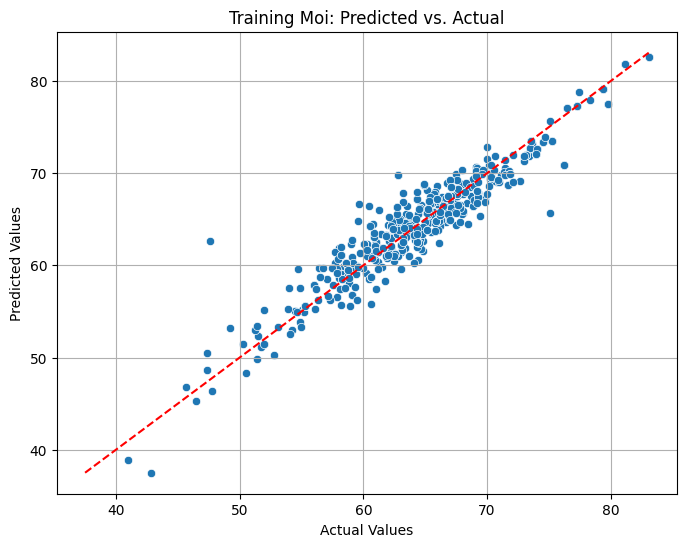

Plot saved to Moi_cv_pp_ps.png


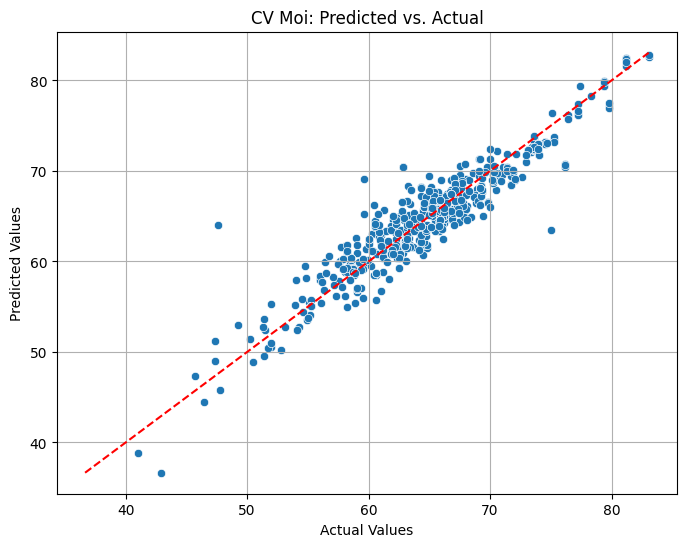

Plot saved to Moi_test_pp_ps.png


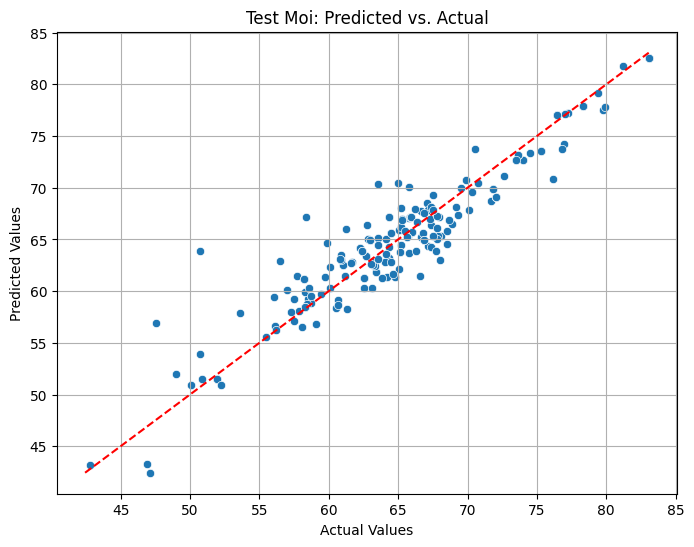

In [51]:
# ================== 7. Visualization (Predicted vs. Actual) ==================
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pp_ps(y_true, y_pred, title, save_path=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    # Add y=x line for reference
    max_val = max(max(y_true), max(y_pred))
    min_val = min(min(y_true), min(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    plt.show()

# Plot for Training set
plot_pp_ps(y_train, y_pred_train, f"Training {target_column}: Predicted vs. Actual", save_path=f"{target_column}_training_pp_ps.png")

# Plot for Cross-Validation set
# Need to make sure y_cv is available from the optimize_pls step
# Assuming optimize_pls has been run and y_cv is available
plot_pp_ps(y_train, y_cv, f"CV {target_column}: Predicted vs. Actual", save_path=f"{target_column}_cv_pp_ps.png")

# Plot for Test set
plot_pp_ps(y_test, y_pred_test, f"Test {target_column}: Predicted vs. Actual", save_path=f"{target_column}_test_pp_ps.png")

In [52]:
# ================== 8. Save Model ==================
import joblib

model_filename = f"{target_column}_pls_model_pp_ps.joblib"
joblib.dump(pls, model_filename)
print(f"\n✅ Model saved as: {model_filename}")


✅ Model saved as: Moi_pls_model_pp_ps.joblib


In [55]:
import os
import zipfile

def zip_specific_files(file_paths, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file_path in file_paths:
            if os.path.exists(file_path):
                arcname = os.path.basename(file_path)
                zipf.write(file_path, arcname)
            else:
                print(f"Warning: File not found - {file_path}")

# List of files to zip
files_to_zip = [
    '/content/Moi_cv_pp_ps.png',
    '/content/Moi_pls_model_pp_ps.joblib',
    '/content/Moi_test_pp_ps.png',
    '/content/Moi_training_pp_ps.png',
    '/content/NDF_cv_pp_ps.png',
    '/content/NDF_pls_model_pp_ps.joblib',
    '/content/NDF_test_pp_ps.png',
    '/content/NDF_training_pp_ps.png',
    '/content/Starch_cv_pp_ps.png',
    '/content/Starch_pls_model_pp_ps.joblib',
    '/content/Starch_test_pp_ps.png',
    '/content/Starch_training_pp_ps.png',
]

# Define the name and path of the zip file
zip_file_name = 'selected_files.zip'
zip_file_path = os.path.join('/content', zip_file_name)

# Create the zip file
zip_specific_files(files_to_zip, zip_file_path)

print(f"Selected files have been zipped to {zip_file_path}")

Selected files have been zipped to /content/selected_files.zip
